In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
model_metadata = pd.read_csv("../../config/models.csv")
palette = model_metadata.set_index("description")["color"].to_dict()
model_metadata

,name,description,color
0,CADD,CADD,C0
1,GPN-MSA,GPN-MSA,C1
2,Borzoi,Borzoi,C2
3,Enformer,Enformer,C3
4,GPN,GPN-Promoter,C4
5,NucleotideTransformer,NT,C5
6,HyenaDNA,HyenaDNA,C6
7,Caduceus,Caduceus,C7


In [4]:
dataset_renaming = {
    "mendelian_matched_9": "Mendelian traits",
    "gwas_matched_9": "Complex traits",
}

subset_renaming = {
    "nonexonic_AND_distal": "Non-exonic\n(distal)",
    "nonexonic_AND_proximal": "Non-exonic\n(proximal)",
    "5_prime_UTR_variant": "5' UTR",
    "3_prime_UTR_variant": "3' UTR",
    "non_coding_transcript_exon_variant": "ncRNA",
}

In [7]:
datasets = [
    "mendelian_matched_9",
    "gwas_matched_9",
]

subsets = [
    "nonexonic_AND_distal",
    "nonexonic_AND_proximal",
    "5_prime_UTR_variant",
    "3_prime_UTR_variant",
    "non_coding_transcript_exon_variant",
]

modalities = [
    "Zero-shot",
    "Linear probing",
]

models = [
    "Borzoi",
    "GPN-MSA",
    "CADD",
]

def get_model_path(model, modality, dataset, subset):
    if modality == "Linear probing":
        predictor = f"{model}.LogisticRegression.chrom"
    elif modality == "Zero-shot":
        if model == "CADD":
            predictor = "CADD.plus.RawScore"
        elif model in ["Enformer", "Borzoi"]:
            predictor = f"{model}_L2_L2.plus.all"
        else:
            if "mendelian" in dataset:
                llr_version = "LLR"
                sign = "minus"
            elif "gwas" in dataset:
                llr_version = "absLLR"
                sign = "plus"
            predictor = f"{model}_{llr_version}.{sign}.score"
    return f"../../results/dataset/{dataset}/metrics_by_chrom_weighted_average/{subset}/{predictor}.csv"

In [8]:
rows = []
for dataset in datasets:
    for subset in subsets:
        for modality in modalities:
            for model in models:
                path = get_model_path(model, modality, dataset, subset)
                df = pd.read_csv(path).iloc[0]
                rows.append([
                    dataset_renaming.get(dataset, dataset),
                    subset_renaming.get(subset, subset),
                    modality,
                    model,
                    df["score"],
                    df["se"],
                ])
df = pd.DataFrame(rows, columns=["dataset", "subset", "modality", "model", "score", "se"])
df

,dataset,subset,modality,model,score,se
0,Mendelian traits,Non-exonic\n(distal),Zero-shot,Borzoi,0.342290,0.138028
1,Mendelian traits,Non-exonic\n(distal),Zero-shot,GPN-MSA,0.819513,0.102417
2,Mendelian traits,Non-exonic\n(distal),Zero-shot,CADD,0.834884,0.079110
3,Mendelian traits,Non-exonic\n(distal),Linear probing,Borzoi,0.353769,0.159389
4,Mendelian traits,Non-exonic\n(distal),Linear probing,GPN-MSA,0.751272,0.140852
5,Mendelian traits,Non-exonic\n(distal),Linear probing,CADD,0.771636,0.105807
6,Mendelian traits,Non-exonic\n(proximal),Zero-shot,Borzoi,0.716308,0.070247
7,Mendelian traits,Non-exonic\n(proximal),Zero-shot,GPN-MSA,0.742556,0.034456
8,Mendelian traits,Non-exonic\n(proximal),Zero-shot,CADD,0.753691,0.044869
9,Mendelian traits,Non-exonic\n(proximal),Linear probing,Borzoi,0.680229,0.091008


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

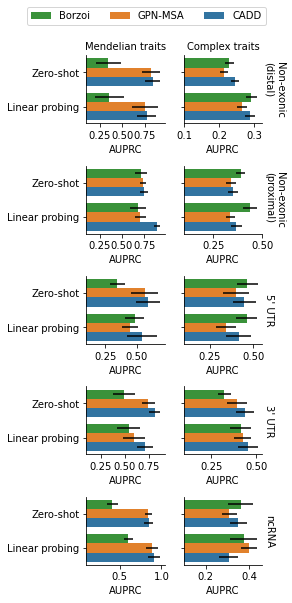

In [9]:
g = sns.FacetGrid(
    data=df.rename(columns={"score": "AUPRC"}),
    row="subset",
    col="dataset",
    margin_titles=True,
    sharex=False,
    sharey=True,
    height=1.6,
    aspect=1.3,
    legend_out=False,
)

def my_boxplot(data, **kwargs):
    # doesn't work, cannot have different orders for zero-shot vs. linear probing
    #data = data.sort_values(["modality", "AUPRC"], ascending=[False, False])
    ax = plt.gca()
    g = sns.barplot(
        data=data,
        y="modality",
        x="AUPRC",
        hue="model",
        ax=ax,
        palette=palette,
    )
    bar_height = g.patches[0].get_height()
    y_coords = sorted([bar.get_y() + bar_height / 2 for bar in g.patches])
    ax.errorbar(
        x=data["AUPRC"],
        y=y_coords,
        xerr=data["se"],
        fmt='none',
        color="black",
    )

g.map_dataframe(my_boxplot)
g.add_legend()

h, l = g.axes[0, 0].get_legend_handles_labels()
g._legend.remove()
g.fig.legend(h, l, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.05))

g.set(
    ylabel="",
    xlim=0.1,
)
g.set_titles(col_template="{col_name}", row_template="{row_name}");
g.tight_layout()
plt.savefig("../../results/plots/performance_by_consequence.pdf", bbox_inches="tight")